# Identifying Fake Bills Using Their Dimensions Through A KNN Model

## **DSCI 100 010 | Group 14**

**By Tejas Shanbhag, Heeya Chung, Chloe Aw, Shresth Agarwal**

# Introduction: 



Counterfeit currency is a significant concern in financial systems posing risks to economic stability and trust. In Canada, the introduction of digital means of counterfeiting peaked in 1994-1998 (Quercioli & Smith, 2015) . Furthermore, digitally produced counterfeit bills were cheaper to make through the use of scanners and color printers. But with technological advancements it has become more challenging to distinguish between genuine and fake bills because of the increasing efforts in replication. 

Differentiating between real and fake bills can be accomplished through the use of the various measurements of the bills, including factors such as each bill’s length and height on both the left and right side of the bill. These measurements are taken in millimeters. 
Therefore, using the ‘Fake Bills’ dataset which includes the use of United States dollar bills, the question we are going to answer using the dataset is: **Is a bill real or fake, given a specific left and right height, lower and higher margins, and length of the bill?** We chose these variables because they have shown the strongest relationship with the detection of genuine bills based on the graphs we have created and analyzed during our exploratory data analysis. 

The **Fake Bills Dataset** was uploaded by Dawn Daras on the Kaggle website: https://www.kaggle.com/datasets/dawndarasms/fakebills?rvi=1. This dataset consists of the mentioned measurements and additional measurements below taken from both real and fake bills which can be used to differentiate between the two classes.



# Methods & Results 

Our project aims to conduct data analysis by classification through the KNN algorithm, using the ‘tidymodels’ library. 

We will analyse each of the variables to determine which ones are appropriate predictors. We will do so by producing boxplots for each variable. Additionally, when producing the model, all predictor variables will be centered and scaled (the variables differ in magnitude as seen in *figure 3*) to ensure that they are all equally accounted for. The classifier will be tuned by applying 5-fold cross-validation with different k-values. In order to choose the best k-value, we will produce a plot depicting k vs. accuracy. After predicting values of the test set, we will produce a confusion matrix to analyse incorrect predictions.

In [3]:
install.packages("themis")

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [4]:
set.seed(9999)
library(tidyverse)  # for general tidyverse functions
library(tidymodels) # for making the training/testing split
library(ggplot2)    # for making the box plots
library(cowplot)    # for arranging the plots in a grid
library(repr)       # for adjusting plot scale
library(themis)     # for upsampling dataset

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [49]:
set.seed(9999)
# reading in the dataset
fake_bills <- read_csv("https://raw.githubusercontent.com/heeyachung/dsci-group-14-/main/fakebills.csv") |> #reading the file
    mutate(is_genuine = as_factor(is_genuine)) |> #factoring the legitimacy variable
    mutate(is_genuine = fct_recode(is_genuine, "real" = "1", "fake" = "2")) |> #renaming values
    drop_na()

#splitting the data into the training and testing split
fake_bills_split <- initial_split(fake_bills, prop = 0.75, strata = is_genuine)
bills_training <- training(fake_bills_split)
bills_testing <- testing(fake_bills_split)
head(bills_training)

Rows: 1500 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (7): is_genuine, diagonal, height_left, height_right, margin_low, margin...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fake,172.28,103.95,103.91,4.78,3.31,111.40
fake,171.92,103.86,104.30,4.96,3.13,111.29
fake,171.59,104.14,104.38,4.97,3.47,111.22
fake,172.02,104.33,104.33,5.19,3.21,111.99
fake,172.55,104.25,104.23,5.60,3.13,111.72
fake,171.63,104.05,104.25,4.61,3.10,110.91


*figure 1: First 6 values of the training data set*

Boxplots for all variables are produced below in order to determine which ones can be used as predictors for our model.

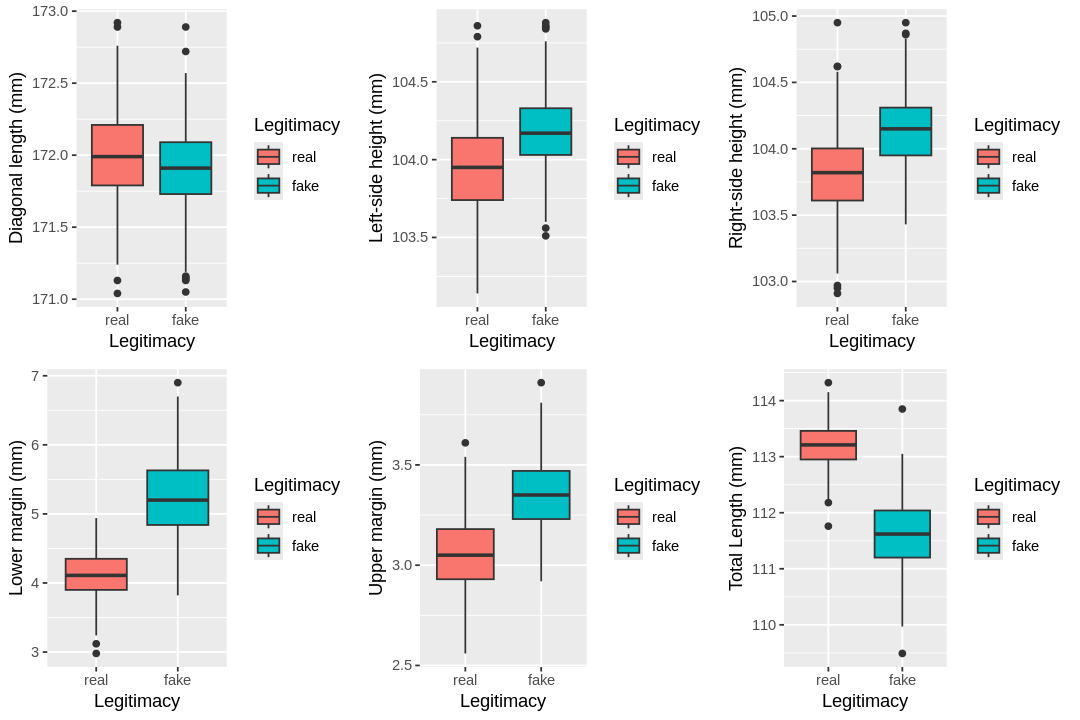

In [50]:
all_plots <- list()

# the legitimacy variable has been added as both the x-variable as well as the fill
# variable in order to encourage redundacy to make the plot more clear.

#boxplot for diagonal length
diag_plot <- bills_training |>
        ggplot(aes(x = is_genuine, y = diagonal, fill = is_genuine)) +
        geom_boxplot() +
        labs(x = "Legitimacy", y = "Diagonal length (mm)", fill = "Legitimacy")
all_plots <- c(all_plots, list(diag_plot))

#boxplot for left-side height
lsh_plot <- bills_training |>
        ggplot(aes(x = is_genuine, y = height_left, fill = is_genuine)) +
        geom_boxplot() +
        labs(x = "Legitimacy", y = "Left-side height (mm)", fill = "Legitimacy")
all_plots <- c(all_plots, list(lsh_plot))

#boxplot for right-side height
rsh_plot <- bills_training |>
        ggplot(aes(x = is_genuine, y = height_right, fill = is_genuine)) +
        geom_boxplot() +
        labs(x = "Legitimacy", y = "Right-side height (mm)", fill = "Legitimacy")
all_plots <- c(all_plots, list(rsh_plot))

#boxplot for lower margin
lower_margin_plot <- bills_training |>
        ggplot(aes(x = is_genuine, y = margin_low, fill = is_genuine)) +
        geom_boxplot() +
        labs(x = "Legitimacy", y = "Lower margin (mm)", fill = "Legitimacy")
all_plots <- c(all_plots, list(lower_margin_plot))

#boxplot for upper margin
upper_margin_plot <- bills_training |>
        ggplot(aes(x = is_genuine, y = margin_up, fill = is_genuine)) +
        geom_boxplot() +
        labs(x = "Legitimacy", y = "Upper margin (mm)", fill = "Legitimacy")
all_plots <- c(all_plots, list(upper_margin_plot))

#boxplot for total length
length_plot <- bills_training |>
        ggplot(aes(x = is_genuine, y = length, fill = is_genuine)) +
        geom_boxplot() +
        labs(x = "Legitimacy", y = "Total Length (mm)", fill = "Legitimacy")
all_plots <- c(all_plots, list(length_plot))

# arranging all plots in a grid with three columns
plot_grid(plotlist = all_plots, ncol = 3)

options(repr.plot.width = 12, repr.plot.height = 12)

*figure 2: Boxplots for all predictor variables with reference to legitimacy*

We will use the columns ‘height_left’, ‘height_right’, ‘margin_low’, ‘margin_upper’, and ‘length’ as our predictor variables. Referring to *figure 2*, the difference of measurements of these columns between the genuine and fake bills is significant enough to use them as predictors between real and fake bills. We will not be using the ‘diagonal’ column, as both the real and fake bills exhibit too similar of values for the diagonal measurement for it to be an accurate determining factor. Below, we select the only the predictor variables, and analyse their mean values.

In [51]:
set.seed(9999)
# Select required columns
selected_bills_training_data = bills_training |>
                    select(is_genuine,height_left, height_right, margin_low,margin_up,length)


# Summary of training set
summary_bills_training_data <- bills_training |>
                    group_by(is_genuine) |>
                    summarize(mean_height_left = mean(height_left),
                             mean_height_right = mean(height_right),
                             mean_margin_low = mean(margin_low),
                             mean_margin_up = mean(margin_up),
                             mean_length = mean(length),
                             total_count=n())

summary_bills_training_data

is_genuine,mean_height_left,mean_height_right,mean_margin_low,mean_margin_up,mean_length,total_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
real,103.9505,103.8113,4.111854,3.055453,113.2016,728
fake,104.1823,104.1375,5.229810,3.349566,111.6213,369


*figure 3: mean values of all predictors*

*figure 3* shows that the mean values of the predictor variables are of differing magnitudes, highlighting the need to scale and center the data. Without scaling, variables with higher mean values will have a greater impact on a given prediction, which would result in inaccuracy.

In [52]:
bills_class <- bills_training |>
    group_by(is_genuine) |>
    summarize(count = n()) 
bills_class

is_genuine,count
<fct>,<int>
real,728
fake,369


*figure 4: Count of real and fake bills*

It can be observed in *figure 4* that there is a significantly greater number of real bills compared to fake. This disparity would be detrimental to the accuracy of our model as it would result in false positives (fake bills predicted real), and can be addressed by upsamping the data. This is done below.

In [53]:
set.seed(9999)
# recipe for upsampling data
fake_bills_recipe <- recipe(is_genuine ~ height_left + height_right + margin_low + margin_up + length, data = bills_training) |>
                step_upsample(is_genuine, over_ratio = 1, skip=FALSE) |>
                prep()

# upsampling the data
upsampled_bills_training <- bake(fake_bills_recipe, bills_training)

# counting the number of real and fake bills after upsampling
summary_bills_training_data_2 <- upsampled_bills_training |>
                    group_by(is_genuine) |>
                    summarize(total_count=n())

summary_bills_training_data_2

is_genuine,total_count
<fct>,<int>
real,728
fake,728


*figure 5: Count of real and fake bills after upsampling*

As seen in *figure 5*, the number of real and fake bills is equal after upsampling. Next, the parameters need to be tuned, that is, the optimal k-value needs to be obtained to ensure the most accurate model possible. This is done below by making a new recipe for the upsampled data, making a model fit for tuning, and finally applying cross-validation with 5 validation sets. Having multiple validation sets ensures greater precision and accuracy when calculating the accuracy of the model. Values from 1 to 10 will be evaluated.

In [54]:
# recipe for upsampled data
fake_bills_recipe_upsampled <- recipe(is_genuine ~ height_left + height_right + 
                                      margin_low + margin_up + length,
                                      data = upsampled_bills_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

In [55]:
set.seed(9999)

# fit for tuning classifier
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# potential k-values
k_vals <- tibble(neighbors = seq(from=1,to=10,by=1))

# cross-validation (5 validation sets)
bills_training_vfold <- vfold_cv(upsampled_bills_training, v=5,strata=is_genuine)

# carrying out cross-validation
vfold_metrics <- workflow() |>
    add_recipe(fake_bills_recipe_upsampled) |>
    add_model(knn_spec) |>
    tune_grid(resamples=bills_training_vfold, grid=k_vals) |>
    collect_metrics()

# filtering for acccuracy
accuracies <- vfold_metrics |> filter(.metric=="accuracy")

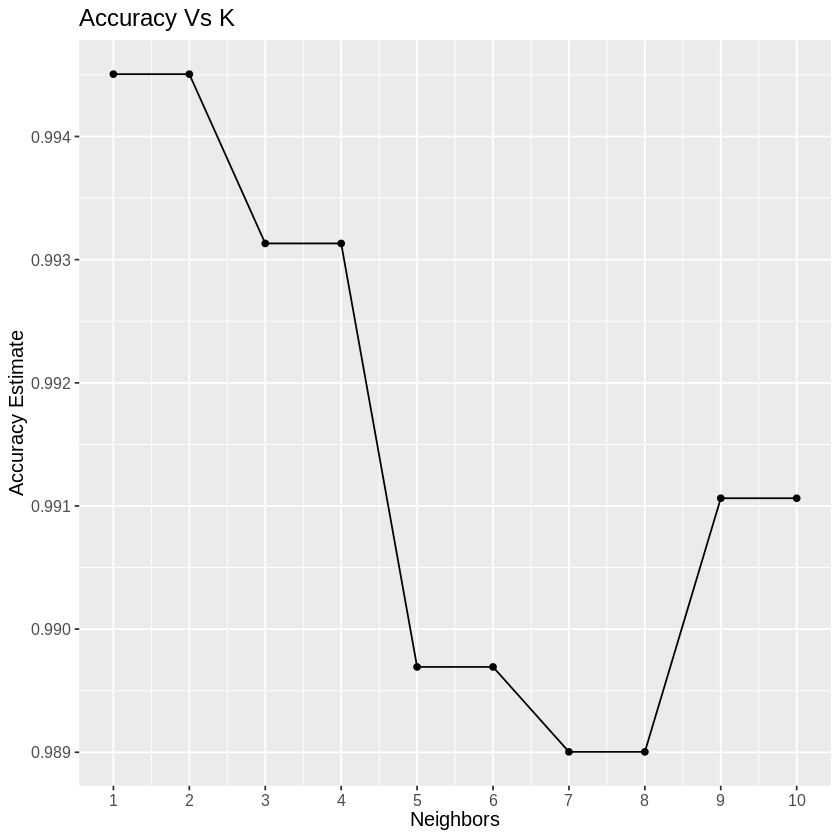

In [33]:
options(repr.plot.width=7,repr.plot.height=7)

accuracy_vs_k <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x="Neighbors", y="Accuracy Estimate") +
    scale_x_continuous(limits=c(1,10), breaks=1:10) +
    theme(text=element_text(size=12)) +
    ggtitle("Accuracy Vs K")
accuracy_vs_k

*figure 6: line plot depicting accuracy vs k*

*figure 6* illustrates that 2 is the k-value with the highest accuracy. Therefore, 2 will be used as the k-value for our model. Below, a new model fit is declared to refit the model, followed by prediction of the legitimacy of the bills in the testing set.

In [56]:
set.seed(9999)
bills_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
            set_engine("kknn") |>
            set_mode("classification")

#recreating the model with the new recipe
bills_fit <- workflow() |>
            add_recipe(fake_bills_recipe_upsampled) |>
            add_model(bills_spec) |>
            fit(data=bills_testing)


#predicting the results of wine_test data
bills_test_predictions <- predict(bills_fit, bills_testing) |>
                            bind_cols(bills_testing)

In [57]:
bills_test_predictions |> metrics(truth=is_genuine, estimate=.pred_class) |> filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,1


*figure 7: model accuracy*

As a last step, we will produce a confusion matrix to get our overall results of our classification model’s predictions. This was used to determine how many classification results were incorrect. The results of the confusion matrix are equal to the original data’s numbers for real and fake bills as there are no false positives or false negatives, correlating with the model’s previous accuracy numbers, which was determined to be 100% (in *figure 7*).

In [58]:
bills_confusion <- bills_test_predictions |>
    conf_mat(truth = is_genuine, estimate = .pred_class)
bills_confusion

          Truth
Prediction real fake
      real  243    0
      fake    0  123

*figure 8: confusion matrix*

We may also visualize the predicted legitimacy vs actual legitimacy with reference to two of the predictor variables. This is done below using margin_low and margin_up.

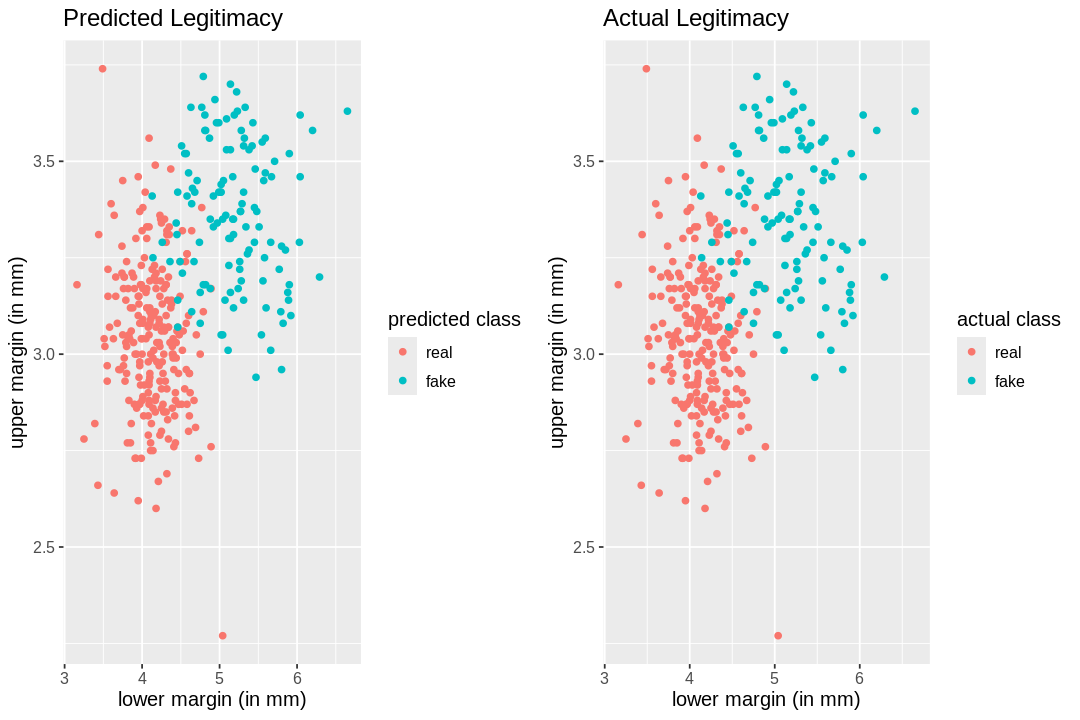

In [59]:
options(repr.plot.width = 9, repr.plot.height = 6)
prediction_plot <- bills_test_predictions |>
    ggplot(aes(x = margin_low, y = margin_up)) +
    geom_point(aes(colour = .pred_class)) +
    labs(x = "lower margin (in mm)",
         y = "upper margin (in mm)",
         colour = "predicted class") +
    theme(text=element_text(size=12)) +
    ggtitle("Predicted Legitimacy")

actual_plot <- bills_test_predictions |>
    ggplot(aes(x = margin_low, y = margin_up)) +
    geom_point(aes(colour = is_genuine)) +
    labs(x = "lower margin (in mm)",
         y = "upper margin (in mm)",
         colour = "actual class") +
    theme(text=element_text(size=12)) +
    ggtitle("Actual Legitimacy")

plot_grid(plotlist = list(prediction_plot, actual_plot) , ncol = 2)

As expected, the two plots are identical, consistent with idea that the model had a 100% accuracy on the testing set.

## Discussion 



Throughout the project, we outlined the steps taken to build our classification model to predict the legitimacy of a bill, given its dimensions. As such, our analysis revealed the relationships between a bill's dimensions and its legitimacy.
Our model achieved a prediction accuracy of 100%, indicating that the classifier made no mistakes in predicting the presence of fake bills in our testing set. The confusion matrix reveals that our model has correctly predicted 243 bills as genuine and 123 bills as fake in the testing set. Based on these outcomes, we can answer our predictive question, confirming that  ‘height_left’, ‘height_right’, ‘margin_low’, ‘margin_upper’, and ‘length’ can be used to accurately predict the presence of fake bills. The high accuracy results from the chosen predictor variables, demonstrating that such predictors are informative factors for distinguishing between classes. Previous research done on the detection of fake bills states that measurement is one of the traditional techniques and approaches factored into detecting fake bills (Shruthy, 2019). 
This raises the acknowledgement of potential limitations of the original data. For example, the ratio of the real and fake bills originally differed, respectively being 2:1. One downside to this would be that our model may not reflect the true disparities in the data when doing its analysis due to one type of observation being more significant than the other. In our attempt to combat this, we resampled the data using the step_upsample function to give us an equal number of real and fake bills, which gave the model a higher chance of correctly detecting the differences between the groups.


Through the model using the KNN classifier, we expected our model to accurately predict whether a bill was a real or fake based on the dimensions of the bill. The model did exactly this; after getting our results back, we found the model was able to classify each bill correctly according to the dataset’s original classifications. Although we did think our model was going to accurately classify many of the bills, we did not expect the model to result in a 100% accuracy. Overall, the model met the standards we set for it.
The accuracy of the model could possibly contribute to its potential use in differentiating between real and fake bills. One impact of counterfeit bills is on those who unknowingly accept such bills consist of bearing the loss caused by the fake bill, consequently receiving no reimbursement and affecting an individual or business’ profits (Counterfeit prevention 2017). Additional research carried out in Pakistan discovered that 26% of the country’s population have received counterfeit money while buying items from the market (Ali et al., 2019).
Specifically, a model such as this can be used in professional spaces such as banks and businesses. By being aware of the significant dimensions of a bill that play a role in its legitimacy, the acceptance of fraudulent bills could significantly decrease. Being able to classify and differentiate between legitimate and counterfeit bills aids in the prevention of further losses to communities and businesses alike, saving themselves from monetary losses.
The use of a classification model in the professional world provides an enhanced judgment on such bills. After using one’s own analysis, the use of a classification model can aid with confirming their own opinion.


In all, the classification model provides insights into the differences between real and fake bills. The dimensions of a bill play a significant role in this classification, with our model demonstrating the potential of such predictors. Some possible questions for further analysis include:
What are other properties of a bill that could be taken into consideration in order to produce a more accurate model?
Were the dimensions we chose truly the best factors to use for determining the legitimacy of a bill?
What other currencies could also be predicted using this exact model? How would we adapt the model to utilize it for other countries’ bills?

## References

Ali, T., Jan, S., Alkhodre, A., Nauman, M., Amin, M., & Siddiqui, M. S. (2019). DeepMoney: counterfeit money detection using generative adversarial networks. PeerJ. Computer science, 5, e216. https://doi.org/10.7717/peerj-cs.216

Counterfeit prevention. Bank of Canada. (2017, February). https://www.bankofcanada.ca/banknotes/counterfeit-prevention/ 
Daras, D. (2024, January 29). Fake Bills. Kaggle. https://www.kaggle.com/datasets/dawndarasms/fakebills 

Shruthy R. (2019). Automated counterfeit banknote detection: a review. International Research Journal of Engineering and Technology (IRJET), 9(7), 283-288. https://www.irjet.net/archives/V9/i7/IRJET-V9I7542.pdf

Quercioli, E., & Smith, L. (2015). The Economics of Counterfeiting. The University of Texas Rio Grande Valley. https://core.ac.uk/download/pdf/294832891.pdf


